### Model Climatology

Simple plot to determine if any models show unusual seasonality

## Necessary Packages

In [1]:
# data analysis
import numpy as np
import pandas as pd
import xarray as xr

import warnings
warnings.filterwarnings("ignore")

# progress bars for loops
from tqdm.notebook import tqdm  

import string
import cftime
import nc_time_axis

from scipy import stats
import datetime



import matplotlib
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

from IPython import display
display.set_matplotlib_formats('retina')

## Data, Models & Variables

In [2]:
variables_for_import = ['mrsos', 'mrsol', 'pr']

experiments = ['historical', 'ssp585']

models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5', 
          'CESM2', 'CESM2-WACCM', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'GISS-E2-1-G',
          'IPSL-CM6A-LR', 'KACE-1-0-G', 'MIROC6', 'MPI-ESM1-2-LR',
          'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM',
          'TaiESM1', 'UKESM1-0-LL']

models.sort()

regions = ['MED', 'WNA']

model_anoms = dict({'MED': dict(), 'WNA': dict()}) 

project_prefix = '~/precip-events'

print_string = '-'

for region in regions:
    fn_prefix = '/exported_data/regions/' + region + '/processed/' 

    for model in tqdm(models): 
        fname = (project_prefix + fn_prefix + model + '_anom_spi_' + print_string.join(variables_for_import) + '.nc')
        
        model_anoms[region][model] = xr.open_dataset(fname, use_cftime = True).load().drop('month')
        
        ## get all the times in datetime and hope this doesn't break anything
        model_anoms[region][model]['time'] = model_anoms[region][model].time.astype("datetime64[ns]")


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [3]:
## defining variables of interest
variables = ['spi_1', 'spi_3', 'spi_6', 'mrsos_anom', 'mrsol_anom']

### Global Warming Levels

Import global warming level crossing times


In [4]:
GWL_crossing_times = pd.read_csv('GWL-crossing_times.csv')
GWL_crossing_times['start_year'] = pd.to_datetime(GWL_crossing_times['start_year'], format='%Y')
GWL_crossing_times['end_year'] = pd.to_datetime(GWL_crossing_times['end_year'], format='%Y')
GWL = GWL_crossing_times

In [5]:
def get_crossing_times(model, level, exp = 'ssp585', GWL = GWL):
    
    if level == 'baseline':
        start_date = pd.Timestamp('1861-01-01')
        end_date = pd.Timestamp('1881-01-01')
    
    else:
        start_date = GWL[(GWL.model == model) & 
                         (GWL.exp == exp) & (GWL.warming_level == level)].start_year.iloc[0]

        end_date = GWL[(GWL.model == model) & 
                       (GWL.exp == exp) & (GWL.warming_level == level)].end_year.iloc[0]
        
    return (start_date, end_date)

In [6]:
def climatology_plot(dictionary_of_model_anoms, region, variable, warming_levels):
    
    model_anoms = dictionary_of_model_anoms
    
    colors = ['grey', 'dodgerblue', 'darkorange', 'firebrick']
    labels = ['Preindustrial Baseline', '1ºC', '2ºC', '3ºC']


    nrows = 5
    ncols = 4

    fig, axarr = plt.subplots(nrows = nrows, ncols = ncols, figsize = [10, 10], sharex = False, sharey = True)

    for ax, model in zip(axarr.flat, models):
        for level, color, label in zip(warming_levels, colors, labels):
            start_date, end_date = get_crossing_times(model, level)
            ds = model_anoms[region][model][variable].sel(time = slice(start_date, end_date)).mean(dim = 'member_id').groupby('time.month').mean()
            if variable == 'pr':
                ds = ds*86400
            if variable == 'mrsol':
                ds = ds.sel(depth = '200cm')
            ds.plot(label = label, ax = ax, color = color)

        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.set_title(model)

        # Subplot lettering from kevin s
        ax.text(0.02,0.98,string.ascii_letters[models.index(model)]+'.',
                transform=ax.transAxes,ha='left',va='top',
                fontsize=15,fontweight='bold',
                bbox={'boxstyle':'round','facecolor':'white','alpha':0.8,'edgecolor':'None','pad':0.1})

    for ax in axarr.flat:
        ax.set_xticks(np.linspace(1,12,12))
        if variable == 'pr':
            ax.set_yticks([0, 1, 2, 3, 4, 5])
        #if variable == 'mrsol' or variable == 'mrsos':
        #    ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
        ax.tick_params(direction='out', colors='k',
                   grid_color='r', grid_alpha=0.5, labelbottom = False)


    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    axarr[4,0].tick_params(labelbottom = True)
    axarr[4,0].set_xticks(np.linspace(1,12,12), months, fontsize = 7,rotation='vertical')
    axarr[4,1].tick_params(labelbottom = True)
    axarr[4,1].set_xticks(np.linspace(1,12,12), months, fontsize = 7,rotation='vertical')  
    axarr[4,2].tick_params(labelbottom = True)
    axarr[4,2].set_xticks(np.linspace(1,12,12), months, fontsize = 7,rotation='vertical')
    axarr[3,3].tick_params(labelbottom = True)
    axarr[3,3].set_xticks(np.linspace(1,12,12), months, fontsize = 7,rotation='vertical')

    # last axis

    ax.axis('off')
    dummy=[]
    for level, color in zip(warming_levels, colors):
        if level == "baseline":
            label = "Preindustrial \nBaseline"
        else:
            label = str(level)+"°C"

        dummy +=[ax.plot([0][0],color=color,label=label)]

    leg=ax.legend()
    leg.set_frame_on(False)

    if region == 'MED':

        if variable == 'pr':
            fig.supylabel('Precipitation (mm/day)', fontweight = 'bold', size = 16)
            fig.suptitle('Mediterranean \n Precipitation Climatology', fontweight = 'bold', fontsize = 20)


        if variable == 'mrsos':
            fig.supylabel('Surface Soil Moisture (kg m-2)', fontweight = 'bold', size = 16)
            fig.suptitle('Mediterranean \n Surface Soil Moisture Climatology', fontweight = 'bold', fontsize = 20)


        if variable == 'mrsol':
            fig.supylabel('Rootzone Soil Moisture (kg m-2)', fontweight = 'bold', size = 16)
            fig.suptitle('Mediterranean \n Rootzone Moisture Climatology', fontweight = 'bold', fontsize = 20)

        
    if region == 'WNA':
        if variable == 'pr':
            fig.supylabel('Precipitation (mm/day)', fontweight = 'bold', size = 16)
            fig.suptitle('Western North America \n Precipitation Climatology', fontweight = 'bold', fontsize = 20)


        if variable == 'mrsos':
            fig.supylabel('Surface Soil Moisture (kg m-2)', fontweight = 'bold', size = 16)
            fig.suptitle('Western North America \n Surface Soil Moisture Climatology', fontweight = 'bold', fontsize = 20)


        if variable == 'mrsol':
            fig.supylabel('Rootzone Soil Moisture (kg m-2)', fontweight = 'bold', size = 16)
            fig.suptitle('Western North America \n Rootzone Moisture Climatology', fontweight = 'bold', fontsize = 20)
    plt.tight_layout()
    plt.savefig('figures/' + region + '_' + variable +'_monthly_climatology.png', dpi = 300, format = 'png')

    

In [8]:
model_anoms['MED']['UKESM1-0-LL']

<xarray.Dataset>
Dimensions:     (time: 3012, member_id: 5, depth: 3)
Coordinates:
  * time        (time) datetime64[ns] 1850-01-16 1850-02-16 ... 2100-12-16
  * member_id   (member_id) object 'r1i1p1f2' 'r2i1p1f2' ... 'r8i1p1f2'
  * depth       (depth) object '30cm' '100cm' '200cm'
Data variables:
    mrsos       (member_id, time) float32 22.26 21.59 18.57 ... 7.059 12.0 17.57
    pr          (member_id, time) float32 2.097e-05 1.424e-05 ... 1.648e-05
    mrsol       (member_id, depth, time) float32 70.47 70.87 ... 388.4 413.0
    spi_1       (member_id, time) float64 0.3492 -0.494 ... -0.7549 0.0263
    spi_3       (member_id, time) float64 nan nan -0.164 ... -1.026 -0.7438
    spi_6       (member_id, time) float64 nan nan nan ... -1.135 -1.329 -1.126
    mrsos_anom  (member_id, time) float32 0.2259 0.05666 ... -1.295 -0.8793
    mrsol_anom  (member_id, depth, time) float32 0.06767 0.08132 ... -1.416

In [7]:
model_anoms['MED']['TaiESM1'].mrsol.sel(depth = '200cm')

<xarray.DataArray 'mrsol' (member_id: 1, time: 3012)>
array([[489.80350417, 490.02028411, 481.48933682, ..., 424.81764782,
        453.47264887, 463.15673736]])
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00
  * member_id  (member_id) object 'r1i1p1f1'
    depth      <U5 '200cm'

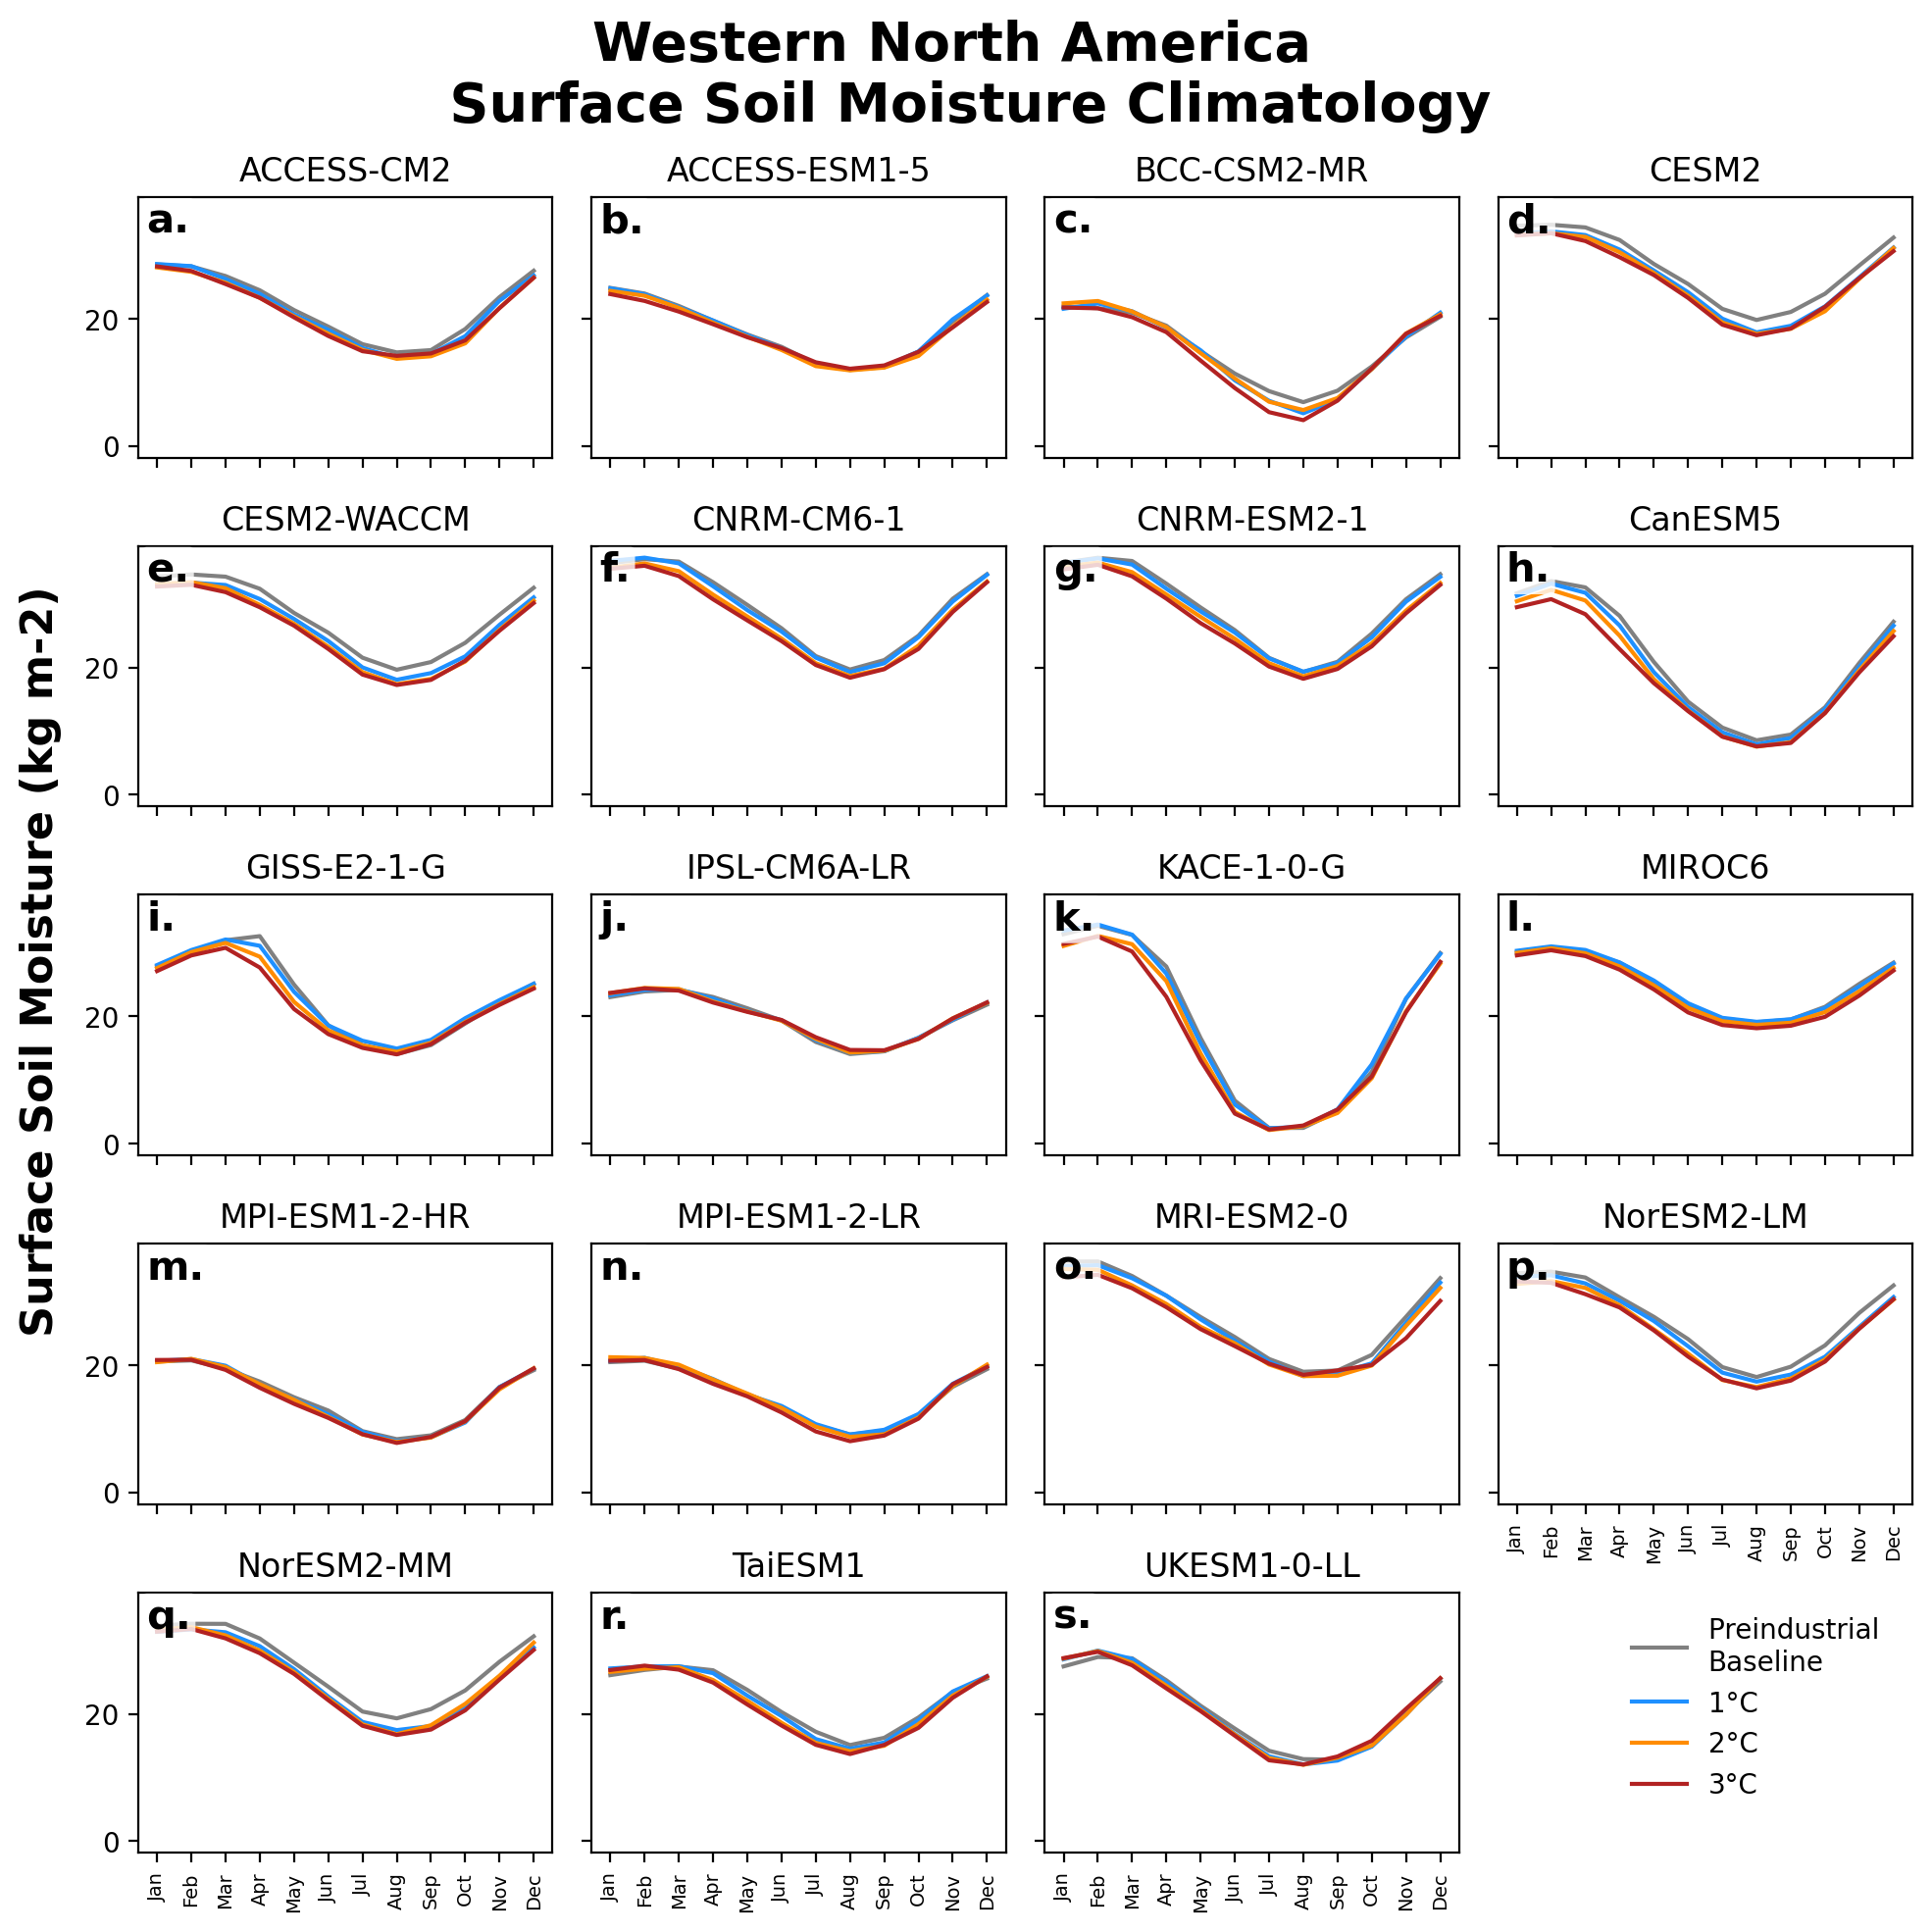

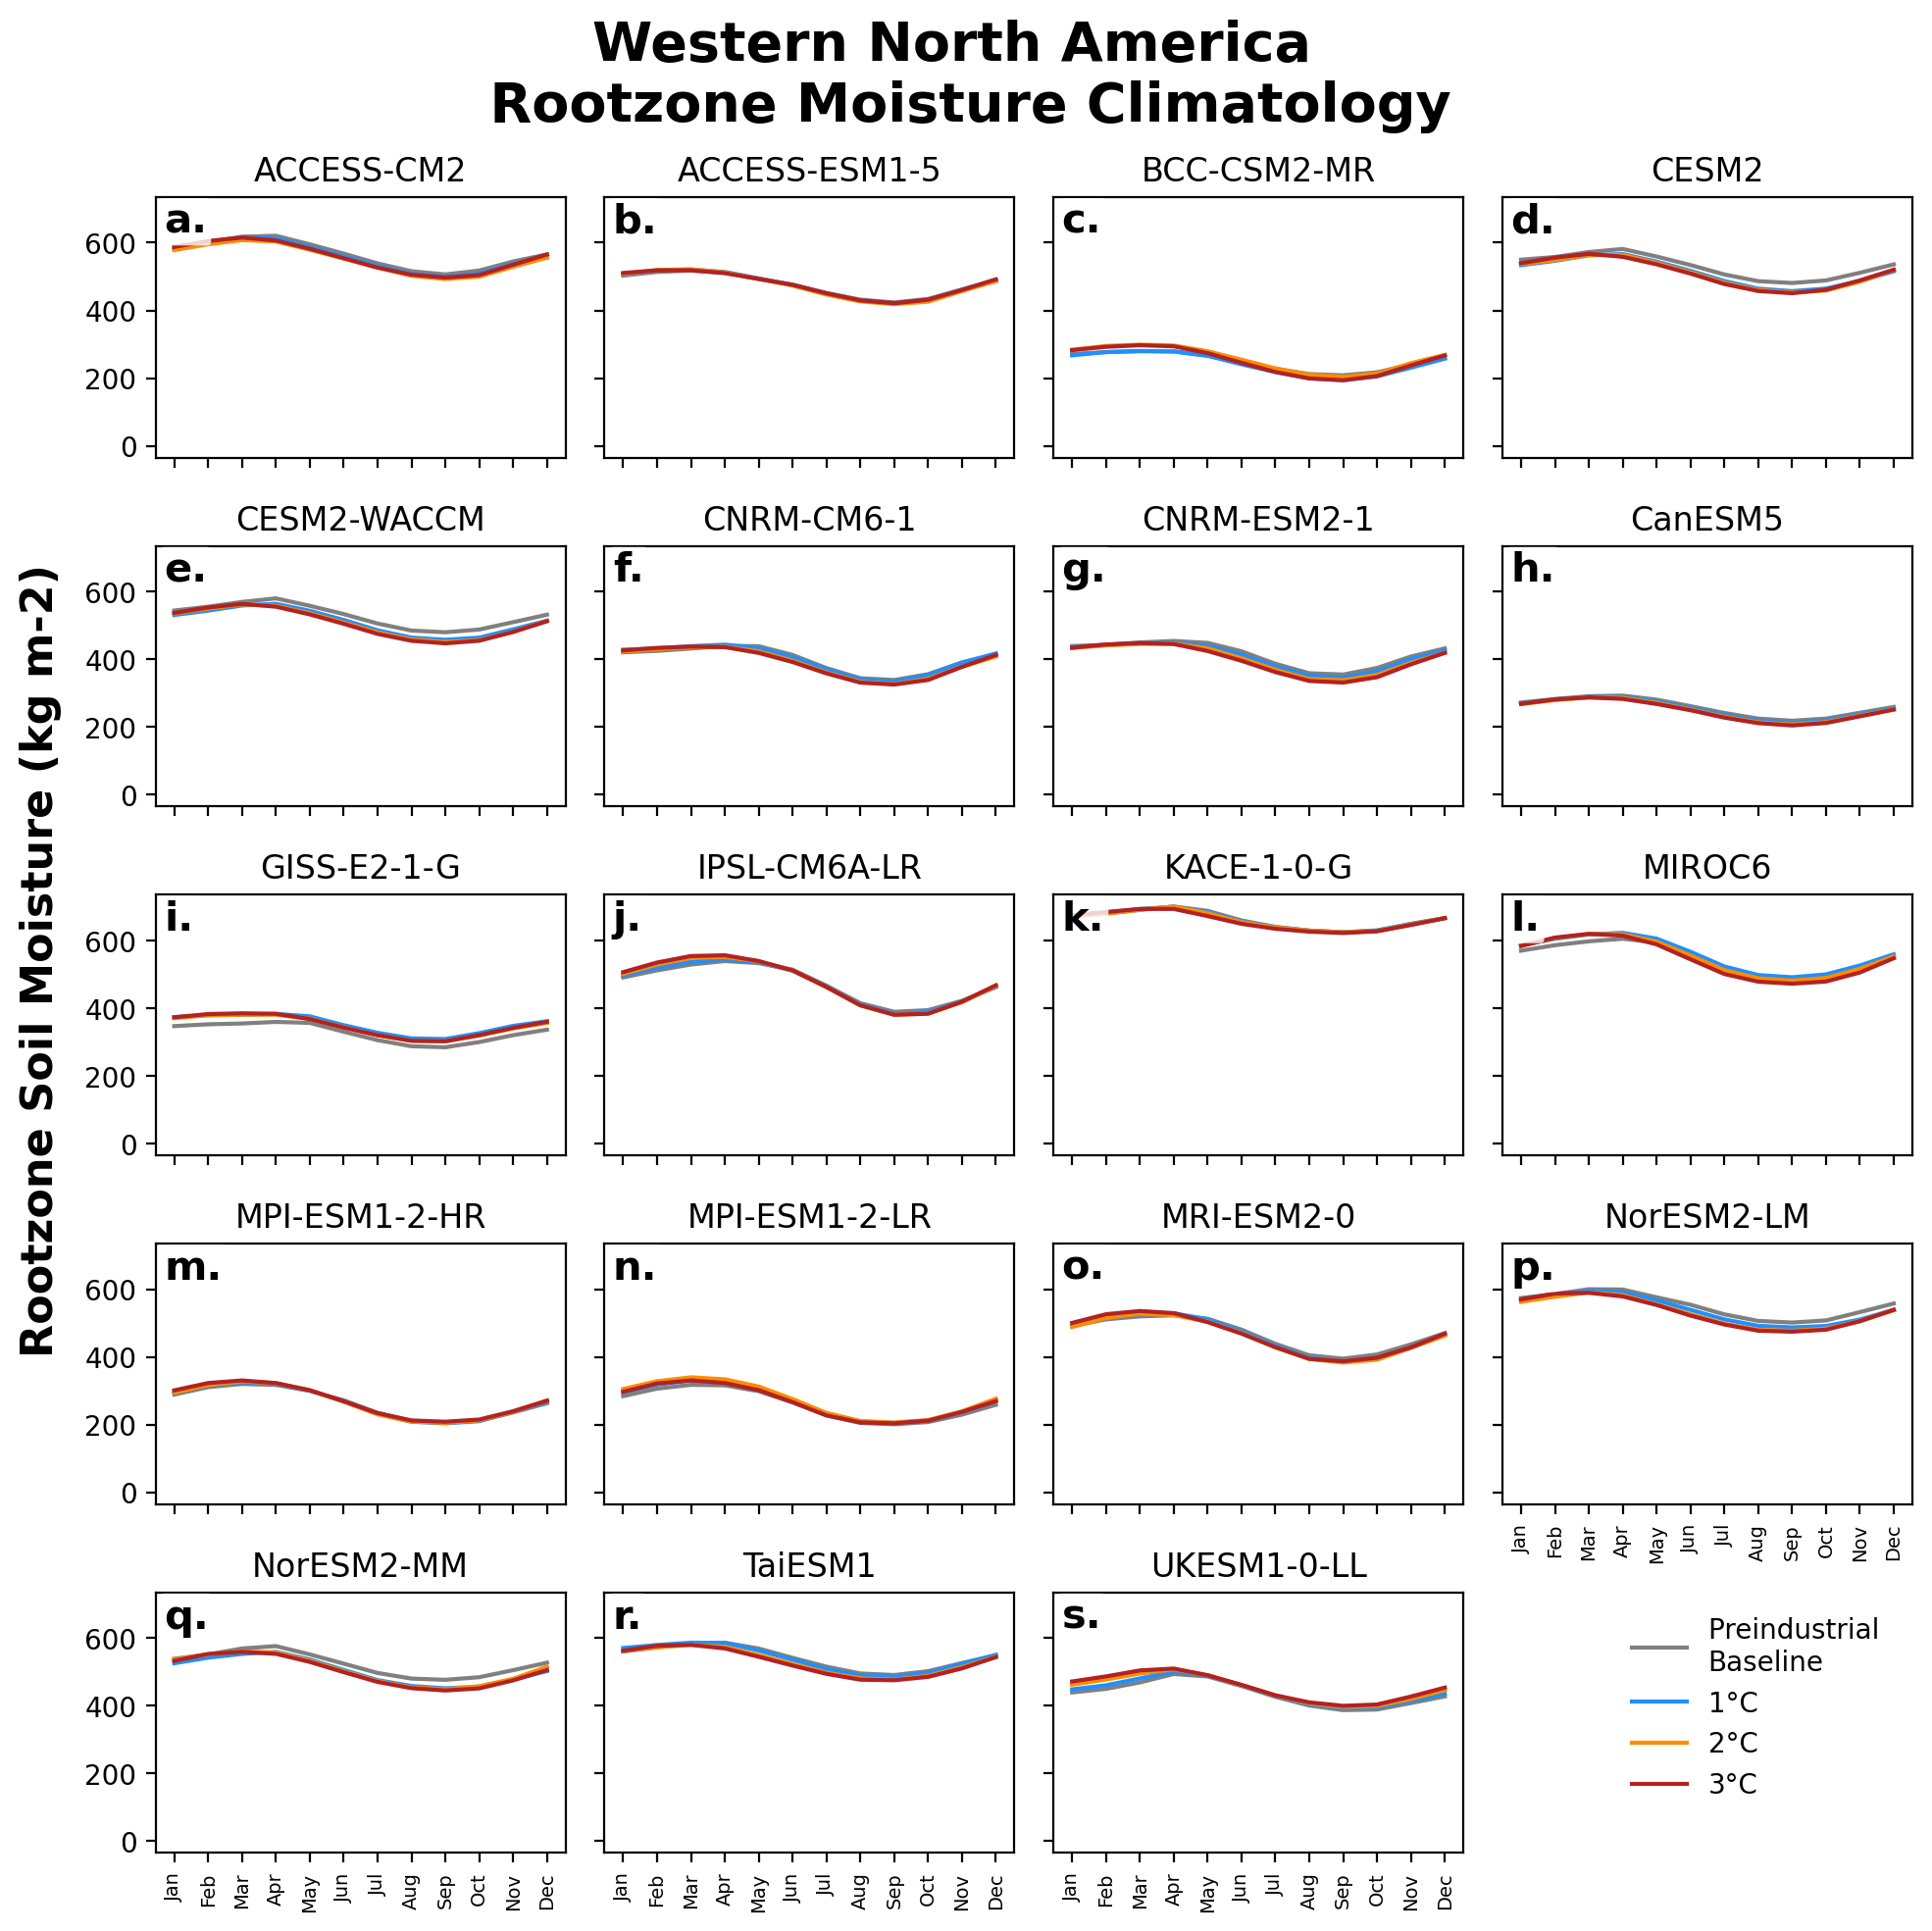

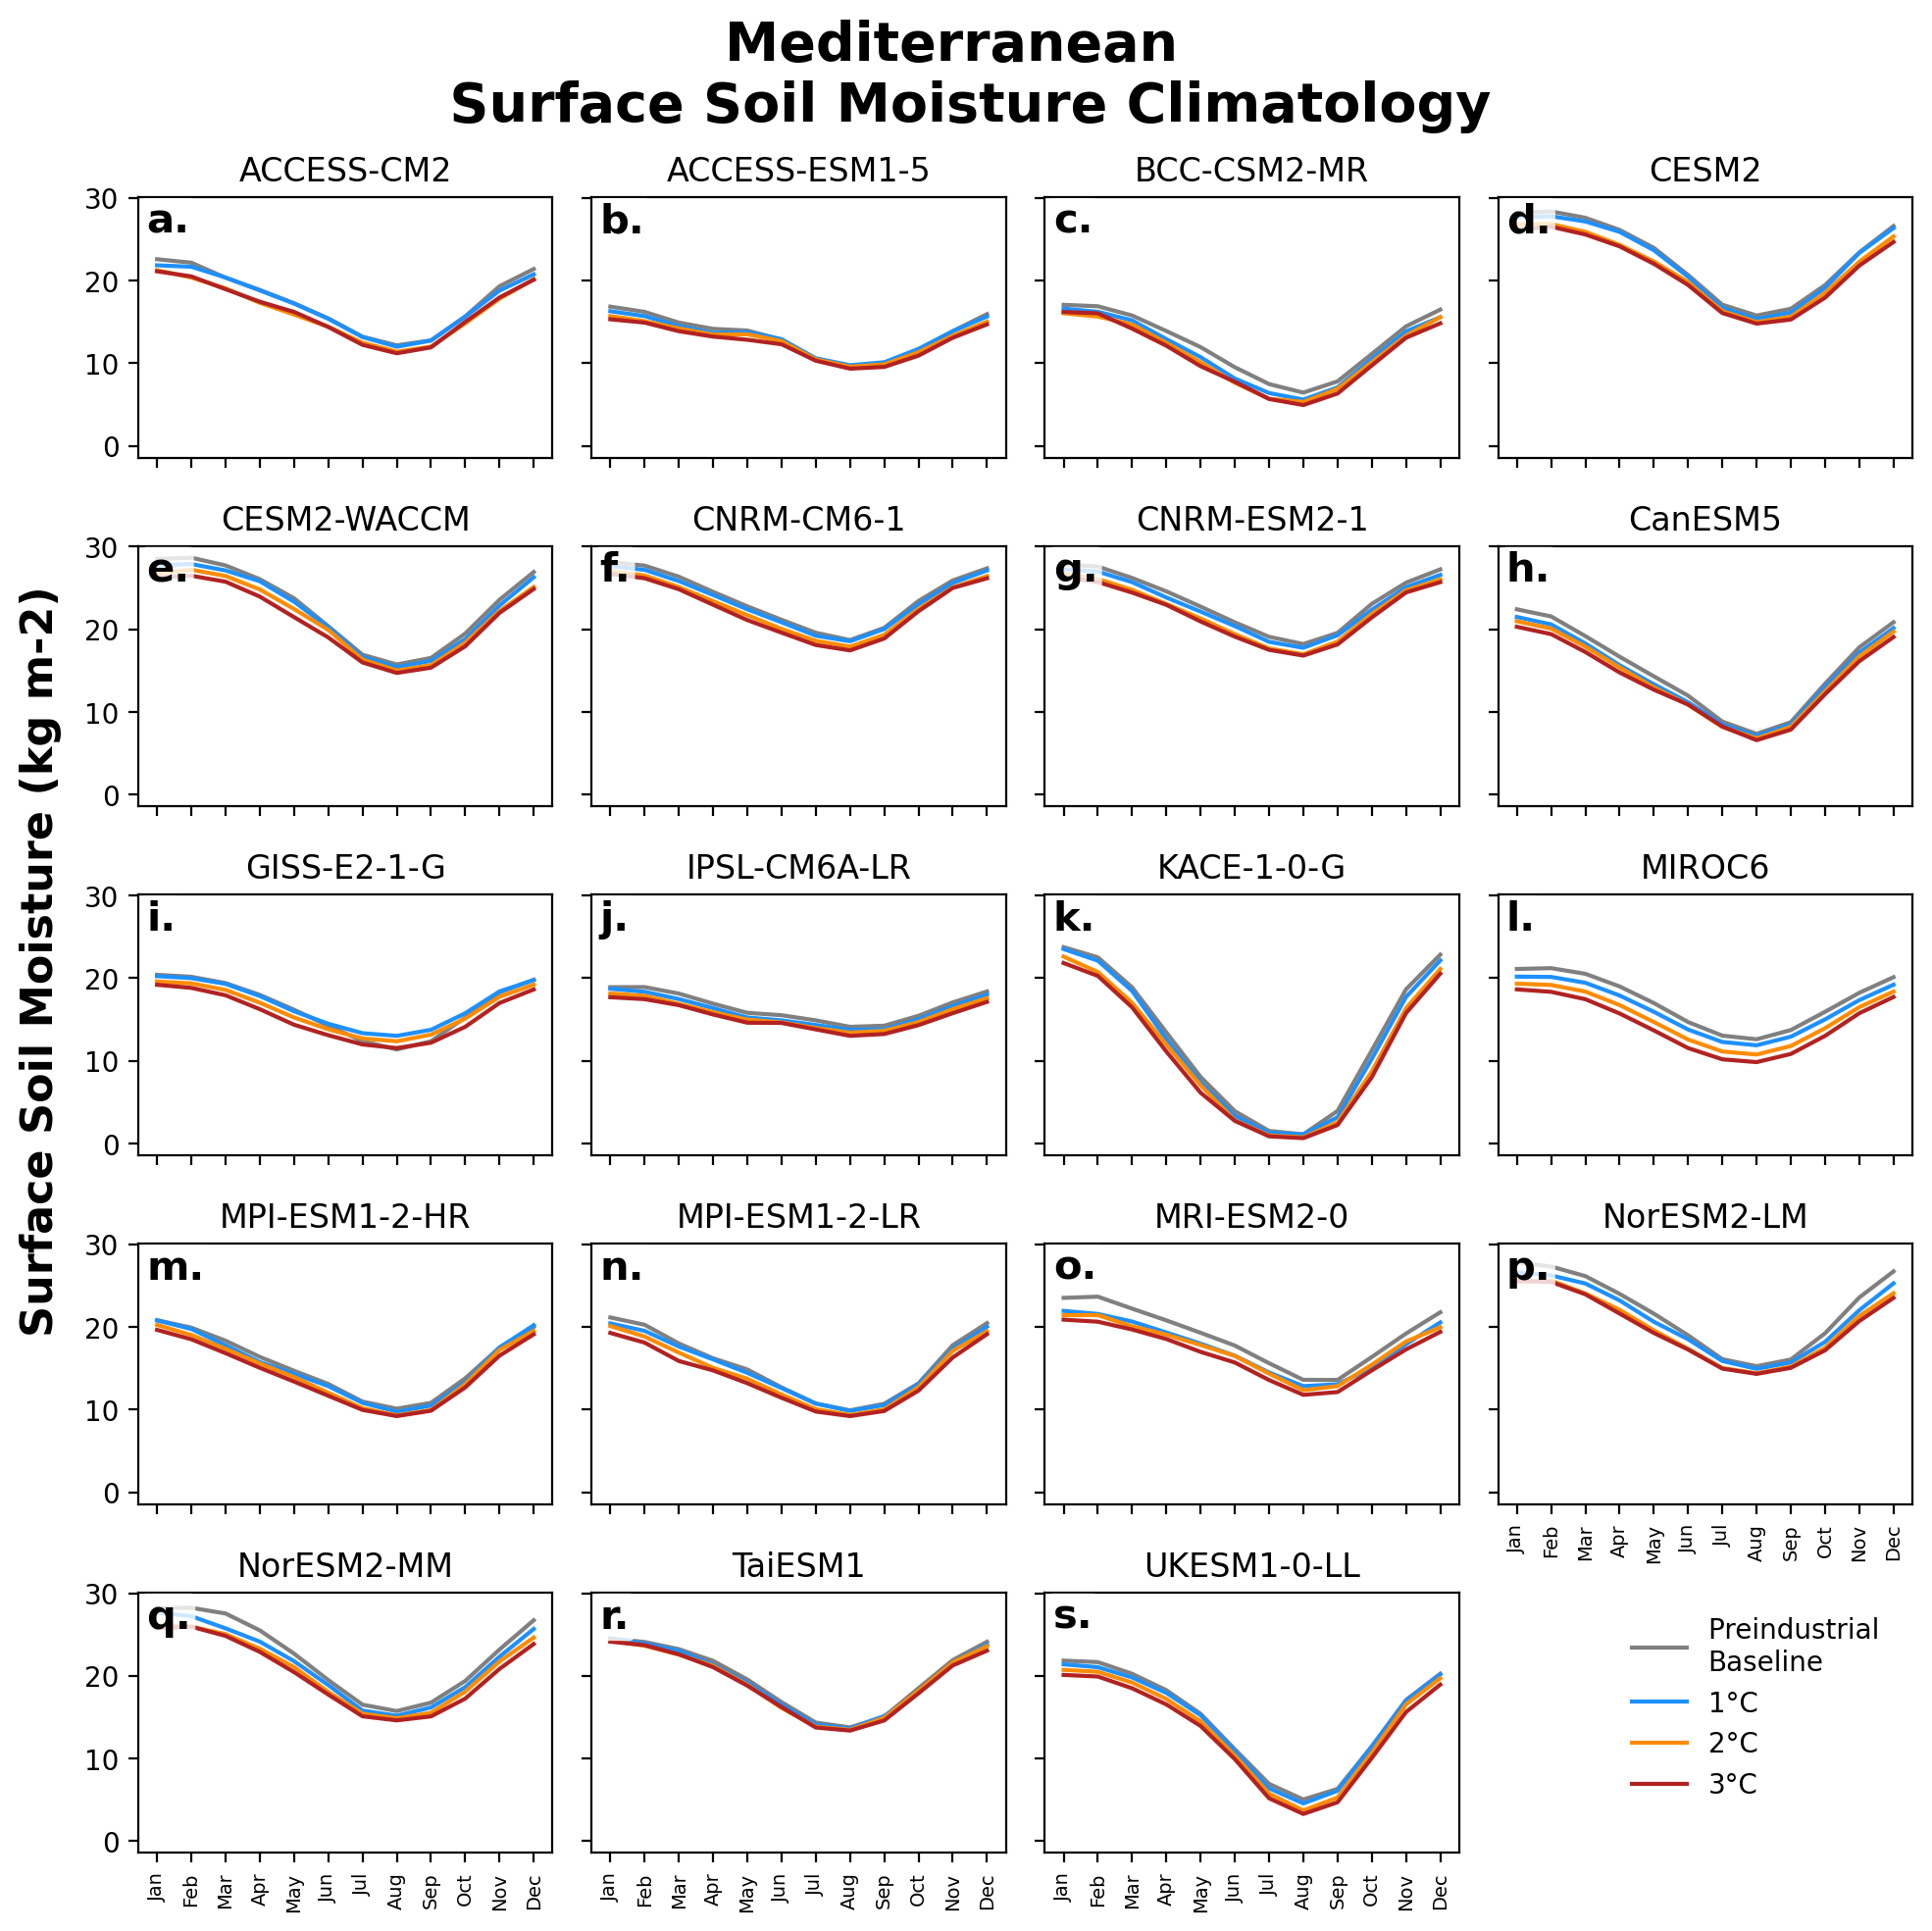

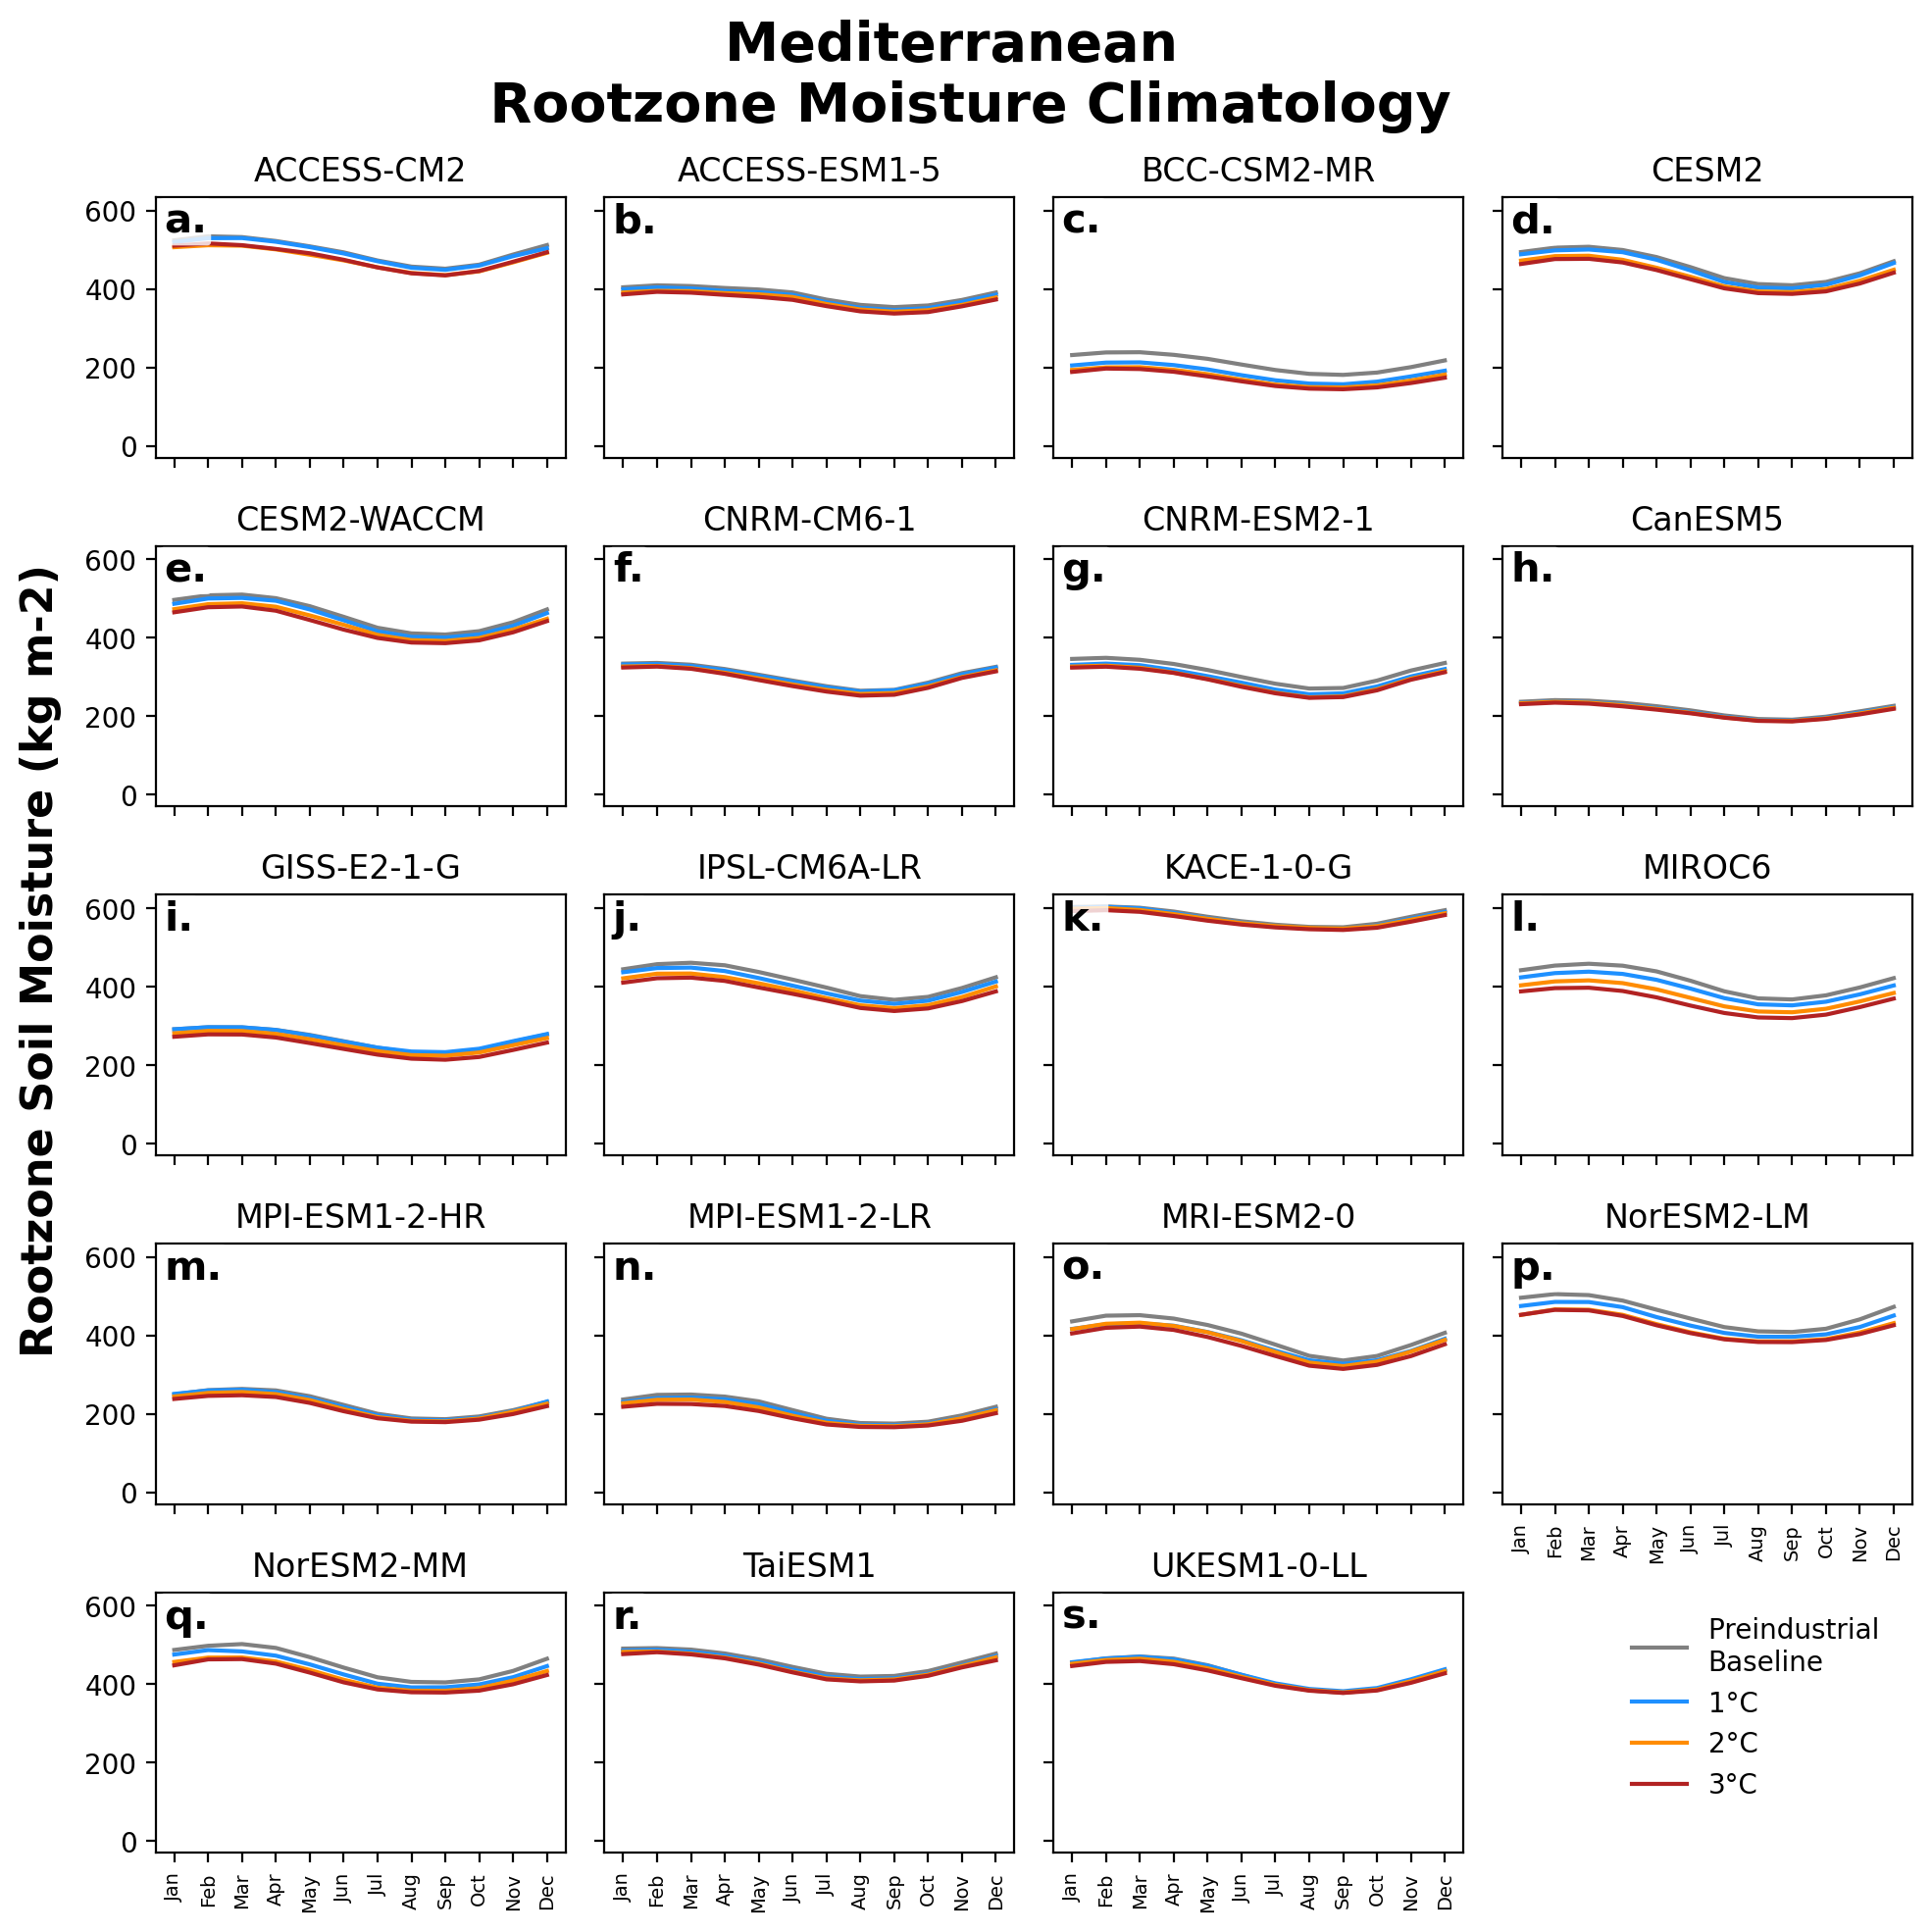

In [8]:
warming_levels = ['baseline', 1, 2, 3]

climatology_plot(model_anoms, 'WNA', 'mrsos', warming_levels)
climatology_plot(model_anoms, 'WNA', 'mrsol', warming_levels)
climatology_plot(model_anoms, 'MED', 'mrsos', warming_levels)
climatology_plot(model_anoms, 'MED', 'mrsol', warming_levels)

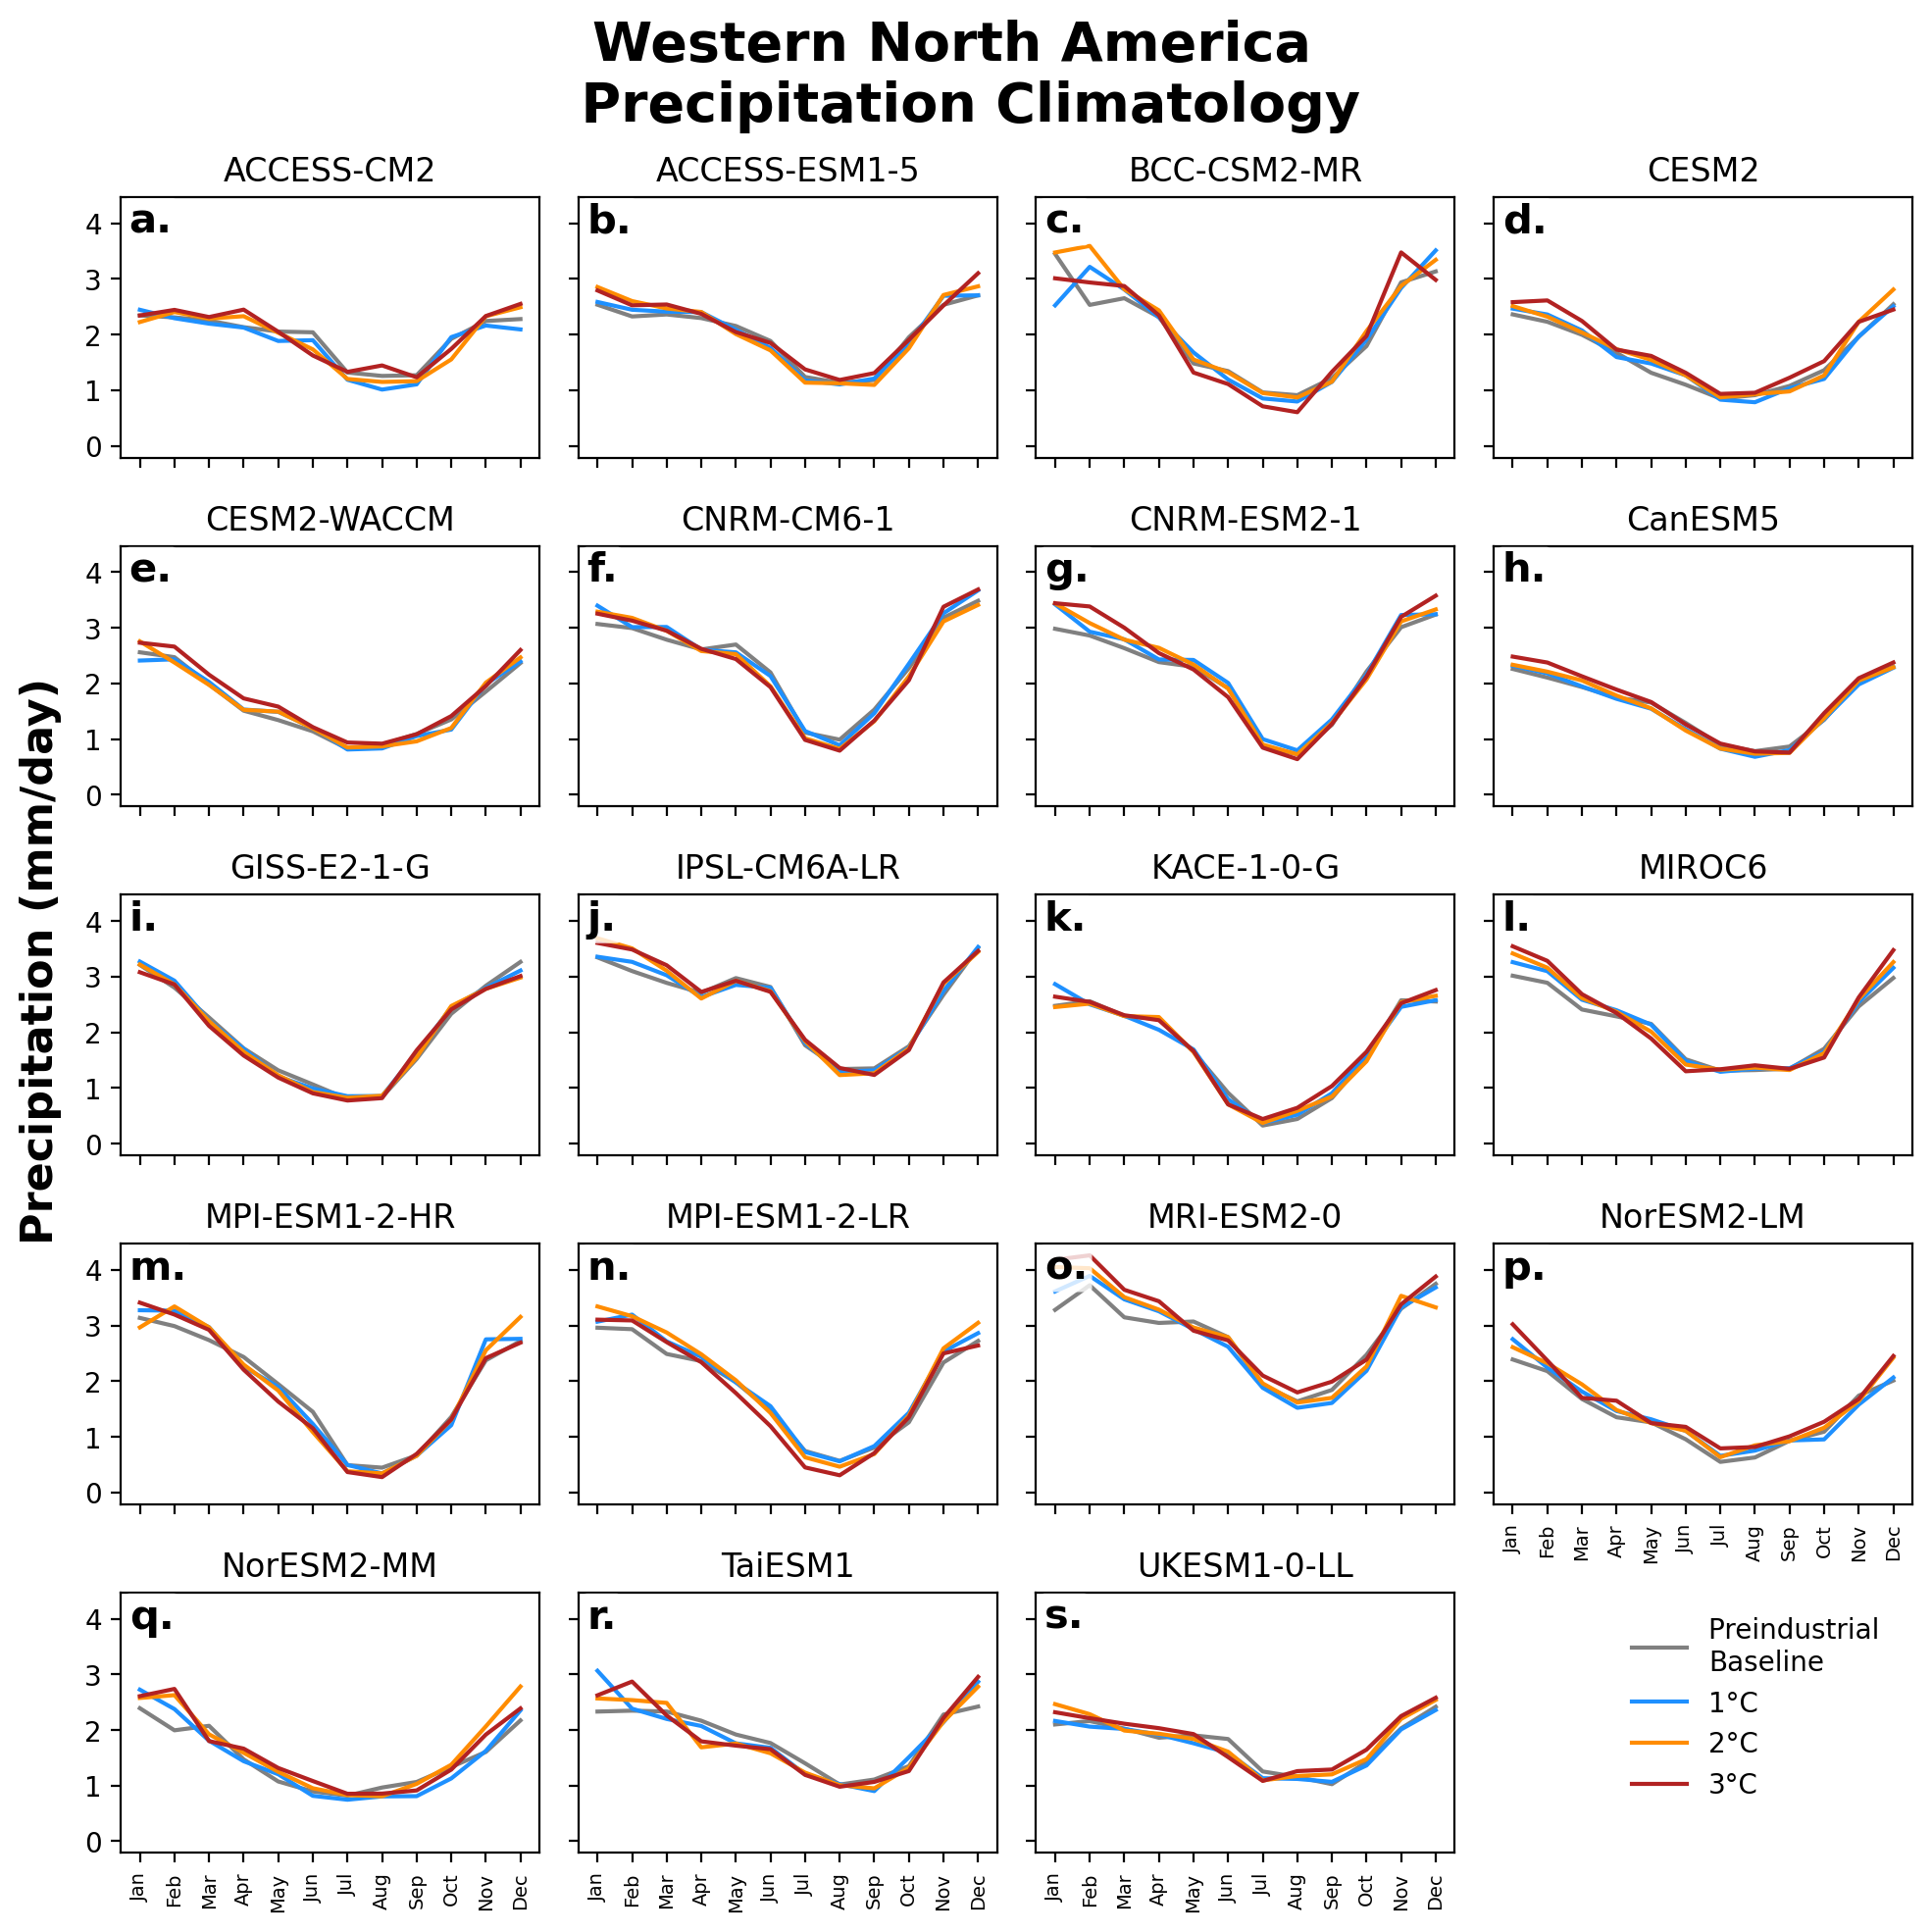

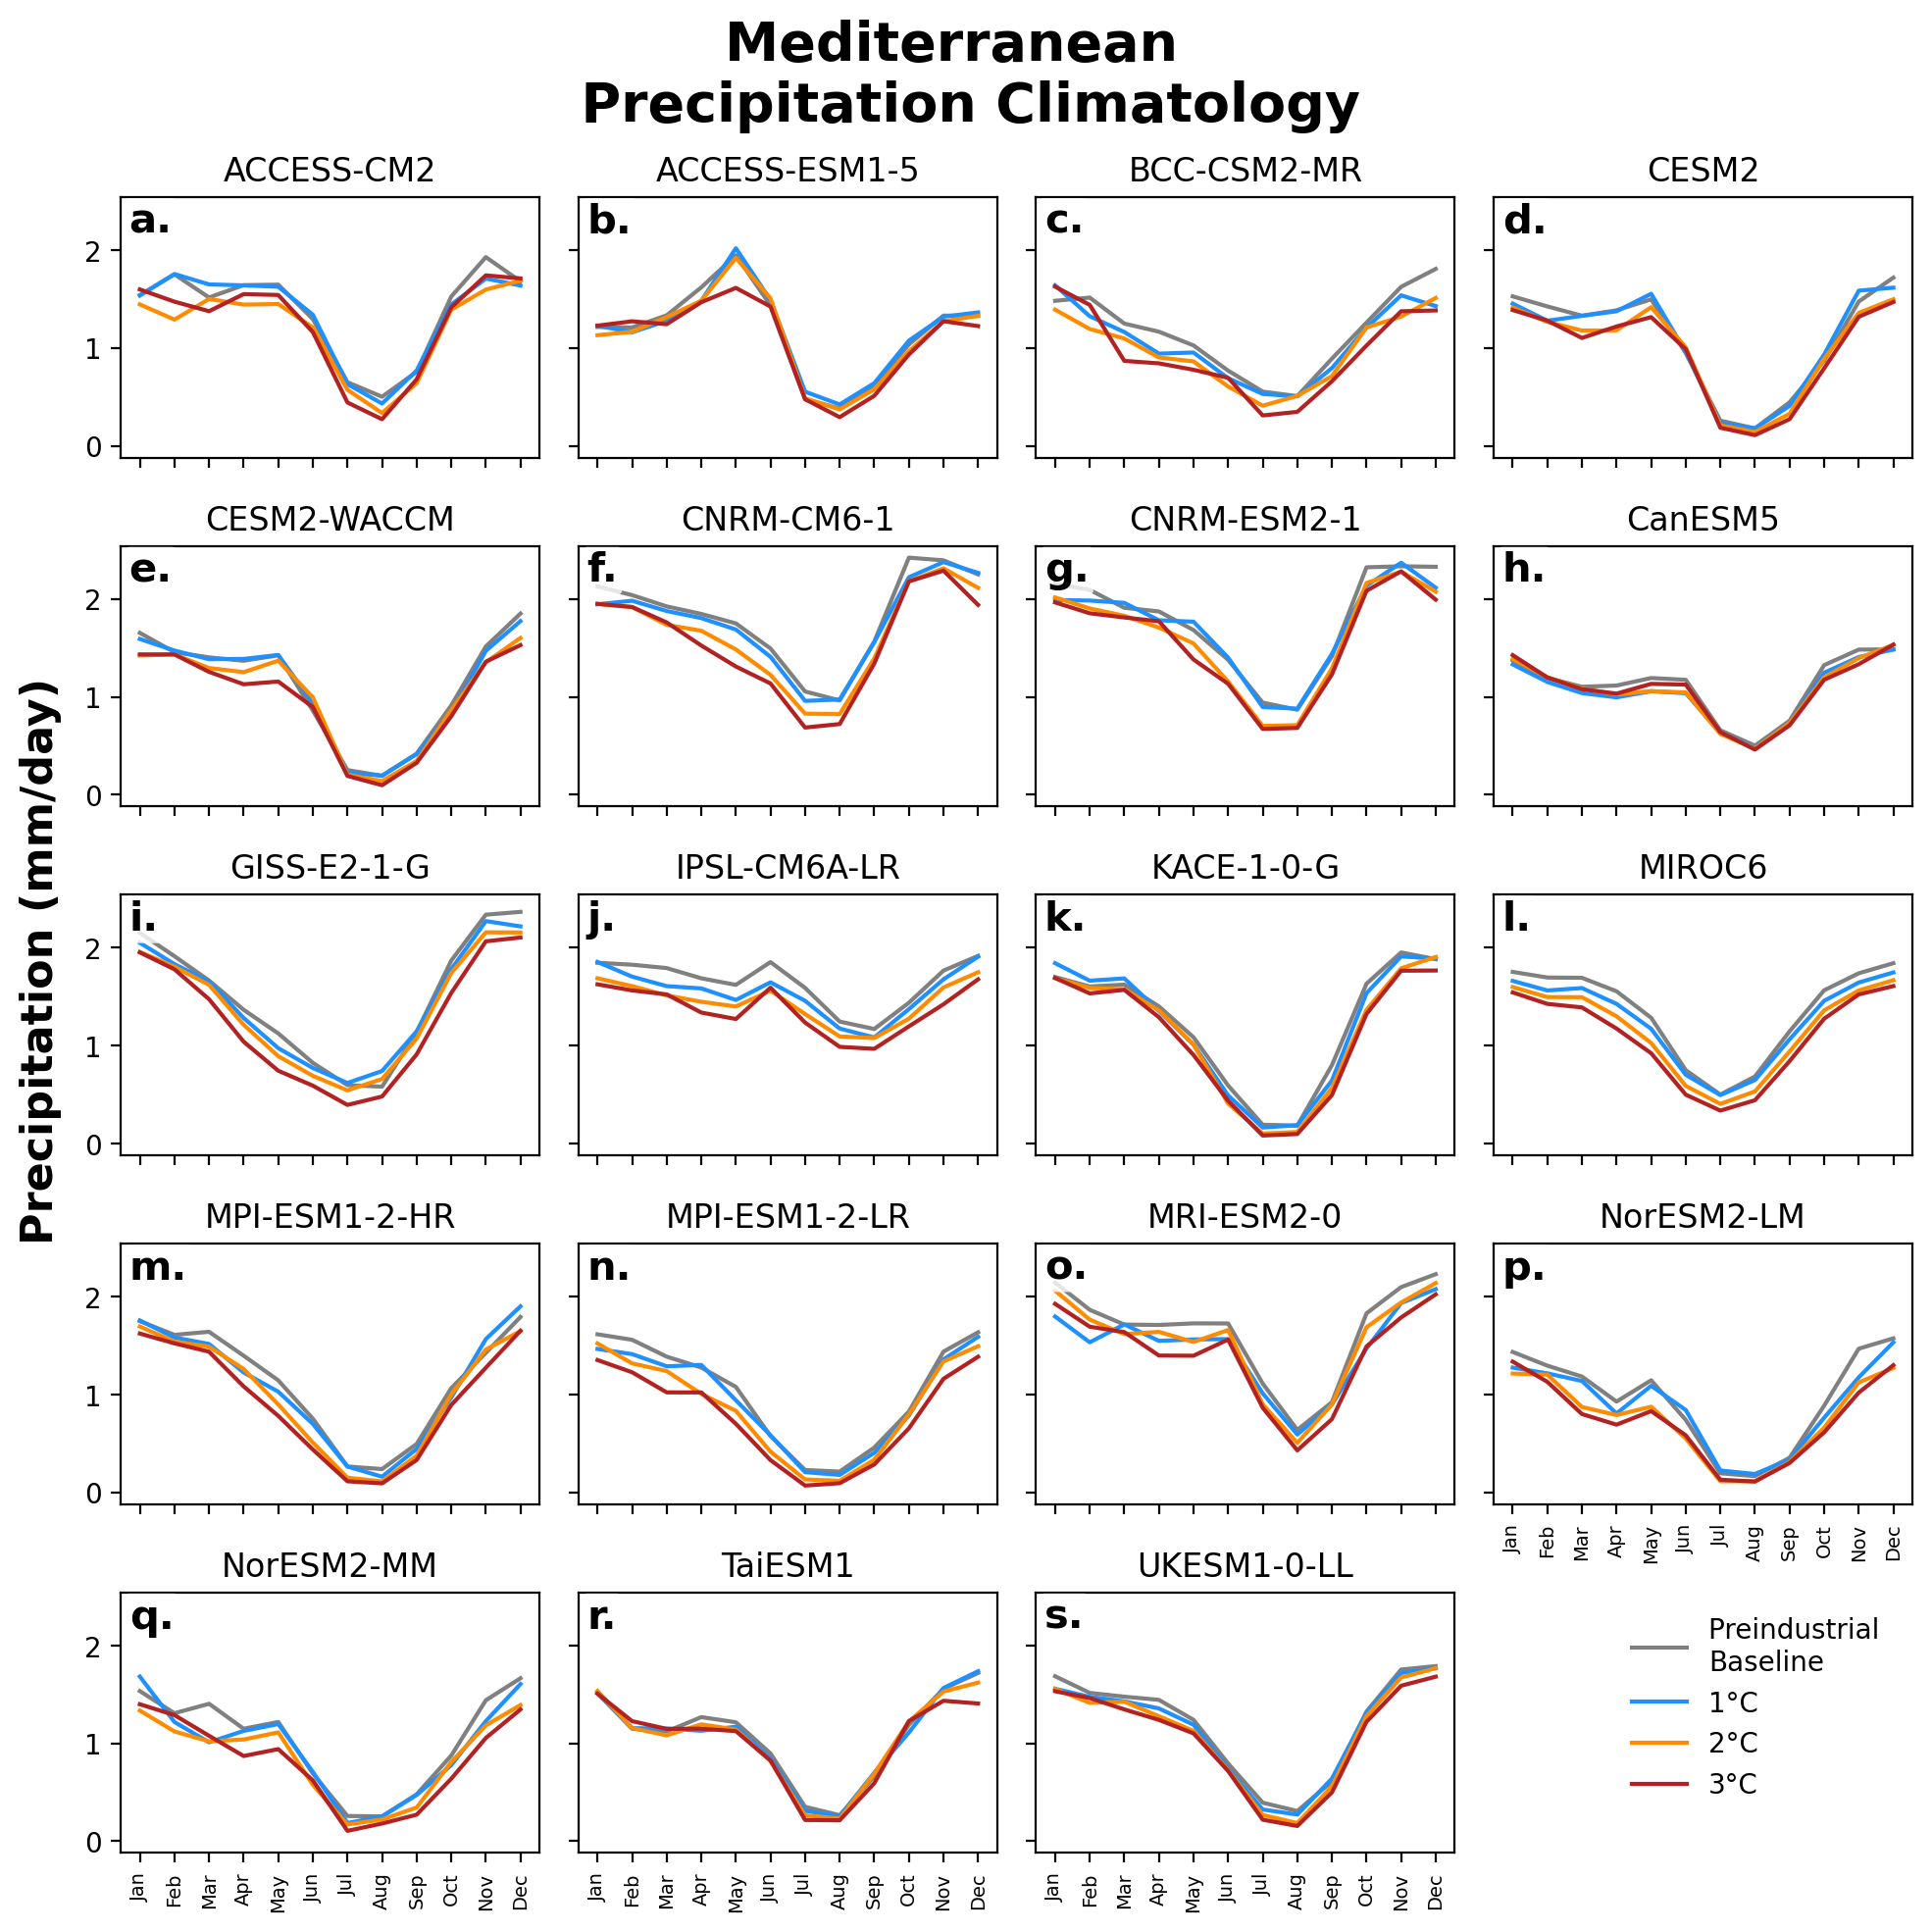

In [9]:

climatology_plot(model_anoms, 'WNA', 'pr', warming_levels)
climatology_plot(model_anoms, 'MED', 'pr', warming_levels)
